In [37]:
import numpy as np
import os
from astropy.table import Table
from astropy.cosmology import FlatLambdaCDM
from matplotlib import pyplot as plt
from astropy.io import ascii
from astropy.coordinates import SkyCoord 
import healpy
import astropy.units as u
import pandas as pd
import matplotlib
import pyccl
from scipy import stats

os.environ['CLMM_MODELING_BACKEND'] = 'ccl' # here you may choose ccl, nc (NumCosmo) or ct (cluster_toolkit)

import clmm
from clmm.support.sampler import fitters

from importlib import reload  

import sys
sys.path.append('../../')
from magnification_library import *

In [38]:
clmm.__version__

'1.0.0'

In [39]:
matplotlib.rcParams.update({'font.size': 14})

In [40]:
#define cosmology

#astropy object
cosmo = FlatLambdaCDM(H0=71, Om0=0.265, Tcmb0=0 , Neff=3.04, m_nu=None, Ob0=0.0448)

#ccl object
cosmo_ccl = pyccl.Cosmology(Omega_c=cosmo.Om0-cosmo.Ob0, Omega_b=cosmo.Ob0,
                      h=cosmo.h, sigma8= 0.80, n_s=0.963)
#clmm object
cosmo_clmm = clmm.Cosmology(be_cosmo=cosmo_ccl)

In [41]:
path_file = '../../../'

In [42]:
key = 'LBGp'

## **Profiles measured with TreeCorr**

In [44]:
quant = np.load(path_file + "output_data/binned_correlation_fct_arcmin_"+key+".npy", allow_pickle=True)
quant_NK = np.load(path_file + "output_data/binned_correlation_fct_NK_arcmin_"+key+".npy", allow_pickle=True)

## **Measuring profiles with astropy and CLMM**


## Open data

In [45]:
gal_cat_raw =  pd.read_hdf(path_file+'input_data/cat_'+key+'.h5', key=key)
dat = np.load(path_file+"input_data/source_sample_properties.npy", allow_pickle=True)
mag_cut, alpha_cut, mag_null, gal_dens, zmean = dat[np.where(dat[:,0]==key)][0][1:]

print (alpha_cut)
mag_cut

3.320964657712193


25.495

In [46]:
selection_source = (gal_cat_raw['ra']>50) & (gal_cat_raw['ra']<73.1) & (gal_cat_raw['dec']<-27.) & (gal_cat_raw['dec']>-45.)
selection = selection_source & (gal_cat_raw['mag_i_lsst']<mag_cut) & (gal_cat_raw['redshift']>1.5)

gal_cat = gal_cat_raw[selection]

In [47]:
[z_cl, mass_cl, n_halo] = np.load(path_file + "output_data/halo_bin_properties.npy", allow_pickle=True)

In [48]:
np.sum(n_halo)

21982.0

## **Magnification profiles prediction**


In [49]:
def Mpc_to_arcmin(x_Mpc, z, cosmo=cosmo):
    return x_Mpc * cosmo.arcsec_per_kpc_proper(z).to(u.arcmin/u.Mpc).value

def arcmin_to_Mpc(x_arc, z, cosmo=cosmo):
    return x_arc * cosmo.kpc_proper_per_arcmin(z).to(u.Mpc/u.arcmin).value 

In [50]:
def magnification_biais_model(rproj, mass_lens, z_lens, alpha, z_source, cosmo_clmm, delta_so='200', massdef='mean', Mc_relation ='Diemer15'):
    
    conc = get_halo_concentration(mass_lens, z_lens, cosmo_clmm.be_cosmo, Mc_relation, mdef[0], delta_so )
    magnification = np.zeros(len(rproj))
    for k in range(len(rproj)):

        magnification[k] = np.mean(clmm.theory.compute_magnification(rproj[k], mdelta=mass_lens, cdelta=conc, 
                                        z_cluster=z_lens, z_source=z_source, cosmo=cosmo_clmm, 
                                        delta_mdef=delta_so, 
                                        massdef = massdef,
                                        halo_profile_model='NFW', 
                                        z_src_model='single_plane'))

        
    model = mu_bias(magnification, alpha) - 1. 
    
    return model, magnification
    

In [51]:
def get_halo_concentration(mass_lens, z_lens, cosmo_ccl, relation="Diemer15", mdef="matter", delta_so=200):
    mdef = pyccl.halos.massdef.MassDef(delta_so, mdef, c_m_relation=relation)
    concdef = pyccl.halos.concentration.concentration_from_name(relation)()
    conc = concdef.get_concentration(cosmo=cosmo_clmm.be_cosmo, M=mass_lens, a=cosmo_clmm.get_a_from_z(z=z_lens), mdef_other=mdef)
    return conc 

Text(0, 0.5, 'pdf')

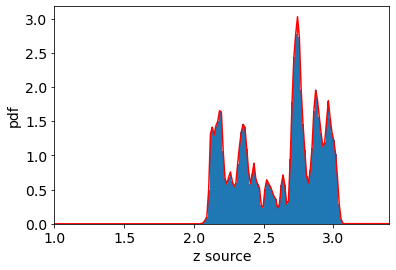

In [52]:
hist = plt.hist(gal_cat['redshift'][selection], bins=100, range=[1.8,3.1], density=True, stacked=True);
pdf_zsource = zpdf_from_hist(hist, zmin=0, zmax=10)
plt.plot(pdf_zsource.x, pdf_zsource.y, 'r')
plt.xlim(1,3.4)

plt.xlabel('z source')
plt.ylabel('pdf')

In [53]:
zint = np.linspace(0, 3.5, 1000)
zrand = np.random.choice(zint, 1000, p=pdf_zsource(zint)/np.sum(pdf_zsource(zint)))

In [54]:
Mc_relation = "Diemer15"
mdef = ["matter", "mean"] #differet terminology for ccl and clmm
delta_so=200


#model with the full redshift distribution
rp = np.logspace(-2, 3, 100)

model_mbias = np.zeros((rp.size, len(z_cl), len(mass_cl)))
model_magnification = np.zeros((rp.size, len(z_cl), len(mass_cl)))

for i in np.arange(z_cl.shape[0]):
    for j in np.arange(mass_cl.shape[1]):
        rp_Mpc = arcmin_to_Mpc(rp, z_cl[i,j], cosmo)
        models = magnification_biais_model(rp_Mpc, mass_cl[i,j], z_cl[i,j], alpha_cut, zrand, cosmo_clmm, delta_so, massdef=mdef[1], Mc_relation=Mc_relation)
        model_mbias[:,i,j] = models[0]
        model_magnification[:,i,j] = models[1]

../../magnification_library.py:92: RuntimeWarning: invalid value encountered in power
  mu_bias = mu**(beta-1)


## **Plotting figures**


## Example for one mass/z bin


In [ ]:
np.sqrt(np.diag(quant[i,j][2])) / (quant[i,j][1] + 1) 

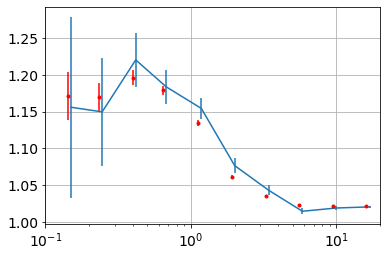

In [86]:
i,j = 1,2

#plt.fill_between(quant[i,j][0], y1= (quant[i,j][1] + 1)- np.sqrt(np.diag(quant[i,j][2])),\
#                 y2 =  quant[i,j][1] +1 + np.sqrt(np.diag(quant[i,j][2])),color = 'grey', alpha=0.4, label='measured')



plt.errorbar(quant[i,j][0]*1.05, np.log(quant[i,j][1] + 1) / (alpha_cut - 1) + np.mean(gal_cat['magnification']), yerr = np.sqrt(np.diag(quant[i,j][2])) /( quant[i,j][1] +1) / (alpha_cut - 1))
plt.errorbar(quant_NK[i,j][0], quant_NK[i,j][1], yerr =  np.sqrt(np.diag(quant_NK[i,j][2])), fmt='r.')
plt.xscale('log')
plt.xlim(0.1,20)
#plt.ylim(-0.25,1)
plt.grid()


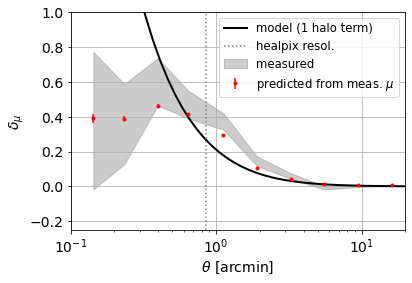

In [79]:
i,j = 1,2

corr = np.mean(gal_cat['magnification']) - 1

plt.fill_between(quant[i,j][0], y1= quant[i,j][1] - np.sqrt(np.diag(quant[i,j][2])),\
                 y2 =  quant[i,j][1]  + np.sqrt(np.diag(quant[i,j][2])),color = 'grey', alpha=0.4, label='measured')

expected_mu_bias = mu_bias(quant_NK[i,j][1] - corr, alpha_cut) - 1.
expected_mu_bias_err =  expected_mu_bias * (alpha_cut -1 ) * np.sqrt(np.diag(quant_NK[i,j][2])) /(quant_NK[i,j][1]) 

plt.errorbar(quant_NK[i,j][0], expected_mu_bias, yerr = expected_mu_bias_err,  fmt='r.', label = 'predicted from meas. $\mu$')


plt.plot(rp, model_mbias[:,i,j],'k', lw=2,  label='model (1 halo term)')


plt.axvline(1*healpy.nside2resol(4096, arcmin = True), linestyle="dotted", color='grey', label ='healpix resol.')

plt.xscale('log')
plt.xlim(0.1,20)
plt.ylim(-0.25,1)
plt.grid()

plt.xlabel('$\\theta$ [arcmin]')
plt.ylabel('$\delta_{\mu}$')

plt.legend(fontsize='small', ncol=1)


## Magnification biais profiles for cluster in mass/z bins

../../magnification_library.py:92: RuntimeWarning: invalid value encountered in power
  mu_bias = mu**(beta-1)


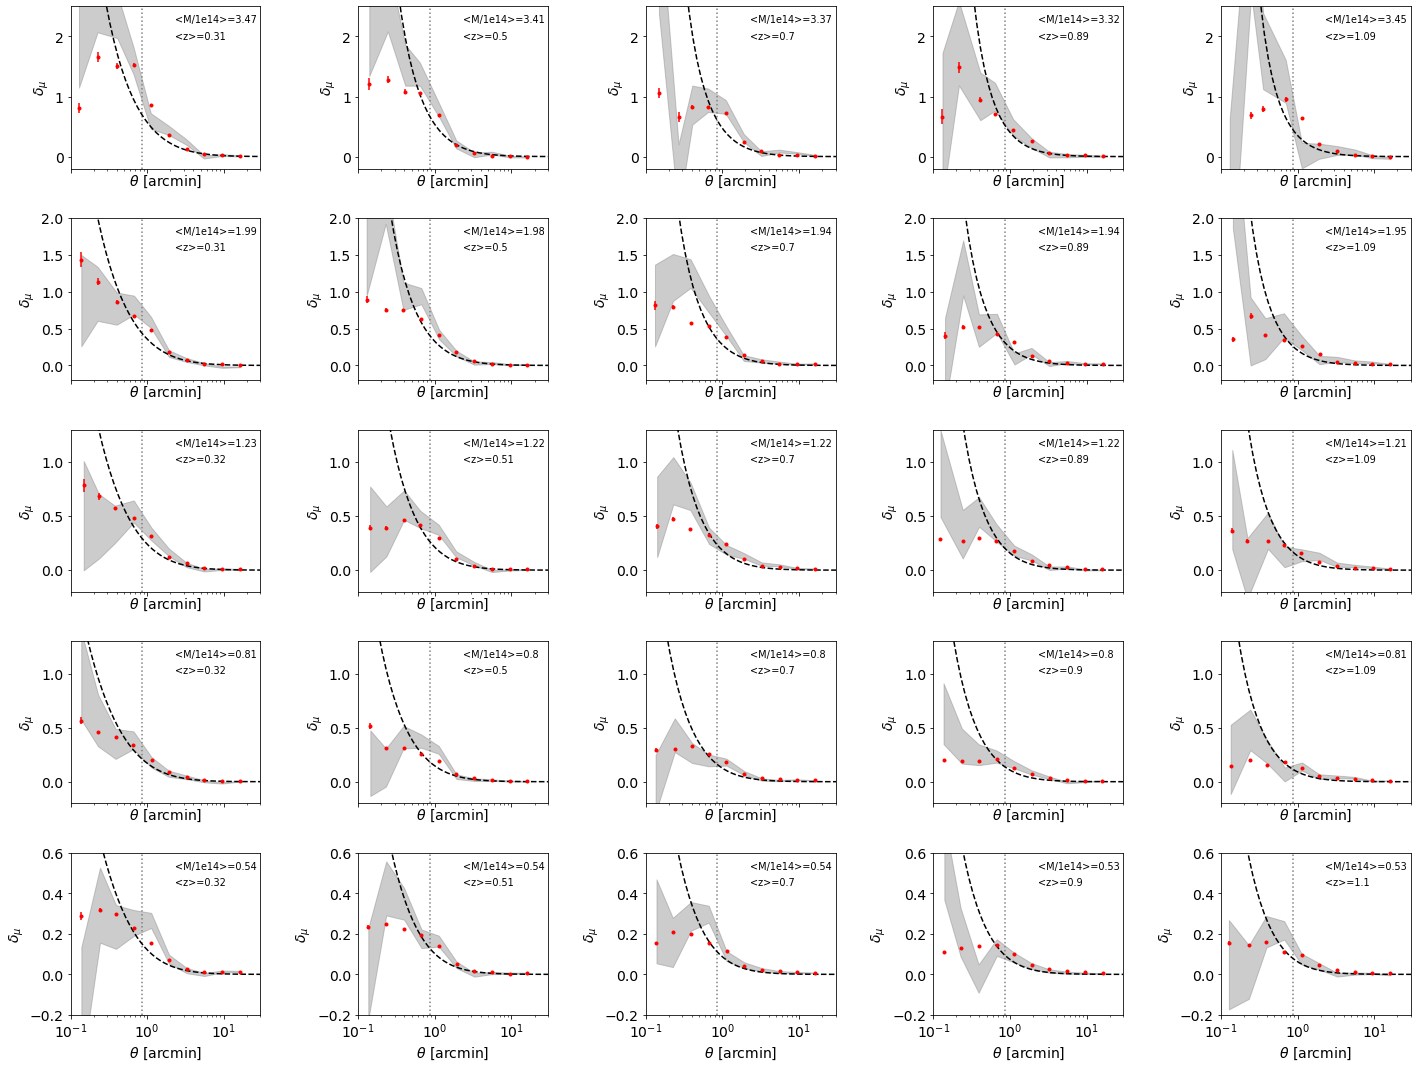

In [56]:
fig, axes = plt.subplots(5,5, figsize=[20,15], sharex=True)

corr = np.mean(gal_cat['magnification']) - 1

for i,h in zip([0,1,2,3,4],range(5)):
    for j,k in zip([0,1,2,3,4],range(5)):
        
        ax = axes[5-1-k,h]
        
        ax.fill_between(quant[i,j][0], y1= quant[i,j][1] -  np.sqrt(np.diag(quant[i,j][2])),\
                 y2 =  quant[i,j][1] + np.sqrt(np.diag(quant[i,j][2])),color = 'grey', alpha=0.4)

        
        expected_mu_bias = mu_bias(quant_NK[i,j][1] - corr, alpha_cut) - 1.
        expected_mu_bias_err =  expected_mu_bias * (alpha_cut -1 ) * np.sqrt(np.diag(quant_NK[i,j][2])) /(quant_NK[i,j][1]) 

        ax.errorbar(quant_NK[i,j][0], expected_mu_bias, yerr = expected_mu_bias_err,  fmt='r.', label = 'predicted from meas. $\mu$')

     
        ax.axvline(1*healpy.nside2resol(4096, arcmin = True), linestyle="dotted", color='grey')
     
        ax.text(0.55, 0.80, "<z>="+str(round(z_cl[i,j],2)), transform=ax.transAxes, fontsize='x-small')
        ax.text(0.55, 0.90, "<M/1e14>="+str(round(mass_cl[i,j]/1e14,2)), transform=ax.transAxes, fontsize='x-small');
          
        ax.set_xlabel('$\\theta$ [arcmin]')
        ax.set_ylabel('$\delta_{\mu}$')

        ax.plot(rp, model_mbias[:,i,j],'k--')
        
plt.tight_layout()


axes[0,0].set_xscale('log')
axes[0,0].set_xlim(0.1,30)

for i in range(axes.shape[0]):
    axes[4,i].set_ylim(-0.2,0.6)
    axes[3,i].set_ylim(-0.2,1.3)
    axes[2,i].set_ylim(-0.2,1.3)
    axes[1,i].set_ylim(-0.2,2.0)
    axes[0,i].set_ylim(-0.2,2.5)